# Optimal Portfolio Allocation


In [289]:
import numpy as np
import pandas as pd
#from joblib import Parallel, delayed
import operator
import matplotlib.pyplot as plt
import cryptocmd as cr
from scipy.optimize import minimize
from datetime import datetime
from matplotlib.pyplot import *
import  plotly.offline as py
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import yfinance as yf
import QuantLib as ql
from pycoingecko import CoinGeckoAPI
from sklearn.decomposition import PCA as sklearnPCA
import json
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from df2gspread import df2gspread as d2g



In [31]:
%qtconsole

In [290]:
scope = ['https://spreadsheets.google.com/feeds','https://www.googleapis.com/auth/drive']
creds = ServiceAccountCredentials.from_json_keyfile_name('C:/Users/tolom/OneDrive/Documenti/Python_Scripts/Status2/PortfolioAllocationStatus/Input/PortfolioAllocation-d9f7af32afdc.json', scope)
client = gspread.authorize(creds)
spreadsheet_key = '1RmMMO_T0B8xpGR-0YM_G57wsmR1bFysq3j9Wb7AJCIE'

In [291]:
input_wks = client.open("PortfolioAllocation") # open sheet
input_sheet = input_wks.get_worksheet(0)

# Retrieve Data

#### Binance

In [292]:
def get_data_to_df(tickers, start_date, end_date):
    df_crypto_dict = dict()
    for ticker in tickers:
        scraper = cr.CmcScraper(ticker, start_date, end_date)
        
        # Pandas dataFrame for the same data
        df = scraper.get_dataframe()
        df = df.set_index("Date")
        df = df.sort_values("Date")
        df_crypto_dict[ticker] = df
    return df_crypto_dict

import pandas as pd
import math
import os.path
import time
from binance.client import Client
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm_notebook #(Optional, used for progress-bars)

### API
#binance_api_key = ''    #Enter your own API-key here
#binance_api_secret = '' #Enter your own API-secret here

### CONSTANTS
#binsizes = {"1m": 1, "5m": 5, "1h": 60, "1d": 1440}
#batch_size = 750
#bbinance_client = Client(api_key=binance_api_key, api_secret=binance_api_secret)


### FUNCTIONS
def minutes_of_new_data(symbol, kline_size, data, source):
    if len(data) > 0:  old = parser.parse(data["timestamp"].iloc[-1])
    elif source == "binance": old = datetime.strptime('1 Jan 2017', '%d %b %Y')
    elif source == "bitmex": old = bitmex_client.Trade.Trade_getBucketed(symbol=symbol, binSize=kline_size, count=1, reverse=False).result()[0][0]['timestamp']
    if source == "binance": new = pd.to_datetime(binance_client.get_klines(symbol=symbol, interval=kline_size)[-1][0], unit='ms')
    if source == "bitmex": new = bitmex_client.Trade.Trade_getBucketed(symbol=symbol, binSize=kline_size, count=1, reverse=True).result()[0][0]['timestamp']
    return old, new

def get_all_binance(symbol, kline_size, save = False):
    filename = '%s-%s-data.csv' % (symbol, kline_size)
    if os.path.isfile(filename): data_df = pd.read_csv(filename)
    else: data_df = pd.DataFrame()
    oldest_point, newest_point = minutes_of_new_data(symbol, kline_size, data_df, source = "binance")
    delta_min = (newest_point - oldest_point).total_seconds()/60
    available_data = math.ceil(delta_min/binsizes[kline_size])
    if oldest_point == datetime.strptime('1 Jan 2017', '%d %b %Y'): print('Downloading all available %s data for %s. Be patient..!' % (kline_size, symbol))
    else: print('Downloading %d minutes of new data available for %s, i.e. %d instances of %s data.' % (delta_min, symbol, available_data, kline_size))
    klines = binance_client.get_historical_klines(symbol, kline_size, oldest_point.strftime("%d %b %Y %H:%M:%S"), newest_point.strftime("%d %b %Y %H:%M:%S"))
    data = pd.DataFrame(klines, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
    if len(data_df) > 0:
        temp_df = pd.DataFrame(data)
        data_df = data_df.append(temp_df)
    else: data_df = data
    data_df.set_index('timestamp', inplace=True)
    if save: data_df.to_csv(filename)
    print('All caught up..!')
    return data_df

def create_df_from_binance(binance_symbols, frequency):
    df = pd.DataFrame()
    for symbol in binance_symbols:
        df = df.append(get_all_binance(symbol, frequency, save = True))
        df["Symbol"] = symbol
    return df

In [293]:
calendar = ql.TARGET()
tenor = ql.Period(ql.Daily)
bussinessConvention = ql.Following
dateGeneration = ql.DateGeneration.Backward

def ql_to_datetime(d):
    datetime(d.year(), d.month(), d.dayOfMonth())
    return datetime(d.year(), d.month(), d.dayOfMonth())


def get_hst_data_coingecko_to_df(id, vs_currency, start_date, end_date, fields):

    date_list = [ ql_to_datetime(x) for x in list(ql.Schedule(start_date, end_date, tenor, calendar, bussinessConvention,
                            bussinessConvention, dateGeneration, False))]
    df = pd.DataFrame(index = date_list, columns=["id"] + fields)
    for date in date_list:
        date_str = date.strftime("%d-%m-%Y")
        json = CoinGeckoAPI().get_coin_history_by_id(id, date_str)
        df.loc[date, "id"] = json["id"]
        for field in fields:
            try:
                df.loc[date, field] = json["market_data"][field][vs_currency]
            except KeyError:
                continue
    return df



In [294]:
def get_input_data(input_sheet):
    input_header = input_sheet.row_values(1)
    rows = input_sheet.get_all_records()
    input_dict = {key : [] for key in input_header}
    for key in input_header:
        for row in rows:
            if row[key] != "":
                input_dict[key].append(row[key])
    return input_dict 

In [295]:
input_dict = get_input_data(input_sheet)
input_dict

{'Crypto': ['bitcoin', 'ethereum', 'ripple', '0x'],
 'Fiat': ['EURUSD=X', 'CHFUSD=X', 'USDGBP=X'],
 'Input File': ['C:/Users/tolom/OneDrive/Documenti/Python_Scripts/Status2/PortfolioAllocationStatus/Input/Dataset2.csv'],
 'Constraint Assets': ['Default Constraints',
  'Turnover',
  'Volatility',
  'USDGBP=X',
  'EURUSD=X',
  'CHFUSD=X',
  'USDGBP=X'],
 'Constraint Group': ['""', 1, 2, 3, 4, 4, 4],
 'Constraint Type': ['""', 'Equal', 'Equal', 'Min', 'Equal', 'Equal', 'Equal'],
 'Constraint Value': ['""', 0.2, 0.5, 0.125, 0.25, 0.25, 0.25],
 'Moments Estimation Methodology': ['PCA'],
 'Portfolio Strategies': ['GMV',
  'MDR',
  'ERC',
  'CAP_WGT',
  'EW',
  'SINGLE ASSET'],
 'Rebalancing Period': [7],
 'Start Date Moments Estimation': ['1-1-2016'],
 'End Date Moments Estimation': ['30-09-2019'],
 'N. Periods Moments Estimation': [252],
 'Frequency Moments Estimation': ['Daily']}

In [296]:
def frequency_mapping():
    if input_dict["Frequency Moments Estimation"][0] == "Daily":
       lag_returns = 1
       is_overlapping = True
    elif input_dict["Frequency Moments Estimation"][0] == "Weekly":
       lag_returns = 5
       is_overlapping = False
    elif input_dict["Frequency Moments Estimation"][0] == "Weekly":
       lag_returns = 21
       is_overlapping = False
    else:
        raise NotImplementedError
    return lag_returns, is_overlapping

In [297]:
crypto_id = input_dict["Crypto"]
fiat_id  = input_dict["Fiat"] 
start_date = ql.Date(int(input_dict["Start Date Moments Estimation"][0].split("-")[0]),
                     int(input_dict["Start Date Moments Estimation"][0].split("-")[1]),
                     int(input_dict["Start Date Moments Estimation"][0].split("-")[2]))
end_date = ql.Date(int(input_dict["End Date Moments Estimation"][0].split("-")[0]),
                     int(input_dict["End Date Moments Estimation"][0].split("-")[1]),
                     int(input_dict["End Date Moments Estimation"][0].split("-")[2]))
method = input_dict["Moments Estimation Methodology"][0]
lag_returns, is_overlapping = frequency_mapping()
input_file = input_dict["Input File"][0]
rebalancing_period = input_dict["Rebalancing Period"][0]


#### Yahoo & Coingecko

In [298]:
assets_id = crypto_id + fiat_id
vs_currency = "usd"

In [299]:
if input_file != "":
    df = pd.read_csv(input_file, index_col=0)
else:
    df = pd.DataFrame(columns=["Symbol", "Close", "Market_Cap", "Volume"])


for symbol in crypto_id:
    if symbol not in df.Symbol.value_counts():
        new_df = get_hst_data_coingecko_to_df(symbol, 
                                              vs_currency, 
                                              start_date, 
                                              end_date, 
                                              ["current_price", "market_cap", "total_volume"])
        new_df
        df_data = pd.DataFrame({"Symbol": new_df["id"], "Close": new_df["current_price"], "Market_Cap": new_df["market_cap"],
                               "Volume": new_df["total_volume"]})
        df = df.append(df_data)

for symbol in fiat_id:
    if symbol not in df.Symbol.value_counts():
        msft = yf.Ticker(symbol)
        new_df = msft.history(period="4y")
        df_data = pd.DataFrame({"Symbol": symbol, "Close": new_df["Close"], "Market_Cap": None,
                               "Volume": new_df["Volume"]})
        df = df.append(df_data)

df.head()

,Symbol,Close,Market_Cap,Volume
Date,,,,
04/01/2016,bitcoin,433.5340,6.522335e+09,1.021958e+09
05/01/2016,bitcoin,432.1150,6.502629e+09,7.582093e+08
06/01/2016,bitcoin,431.3430,6.492499e+09,8.333419e+08
07/01/2016,bitcoin,456.4340,6.870165e+09,1.637949e+09
08/01/2016,bitcoin,454.6963,6.847658e+09,1.501743e+09


In [300]:
df.Symbol.value_counts()

CHFUSD=X    1041
USDGBP=X    1041
EURUSD=X    1041
ethereum     958
bitcoin      958
0x           958
ripple       958
Name: Symbol, dtype: int64

In [301]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6955 entries, 04/01/2016 to 30/09/2019
Data columns (total 4 columns):
Symbol        6955 non-null object
Close         6495 non-null float64
Market_Cap    3372 non-null float64
Volume        6495 non-null float64
dtypes: float64(3), object(1)
memory usage: 271.7+ KB


In [302]:
df.index = pd.to_datetime(df.index, format="%d/%m/%Y")
df[["Close", "Market_Cap", "Volume"]] = df[["Close", "Market_Cap", "Volume"]].astype("float64")

In [303]:
df.describe()

,Close,Market_Cap,Volume
count,6495.000000,3.372000e+03,6.495000e+03
mean,721.409414,3.246512e+10,1.216037e+09
std,2246.743223,5.022152e+10,3.944342e+09
min,0.005104,7.246236e+07,0.000000e+00
25%,0.759000,6.897027e+08,0.000000e+00
50%,1.032869,1.243492e+10,7.931910e+05
75%,15.038508,3.450887e+10,5.385130e+08
max,19188.053960,3.210000e+11,5.694896e+10


#### Adjust Dates

In [304]:
date_list = [ ql_to_datetime(x) for x in list(ql.Schedule(start_date, end_date, tenor, calendar, bussinessConvention,
                            bussinessConvention, dateGeneration, False)) if ql_to_datetime(x) in list(df[df["Symbol"] == assets_id[-1]].index)]

In [305]:
df = df.loc[date_list]

## Returns

In [306]:
df["USDGBP"] = None
df["USDGBP"] = df.reset_index()["Date"].apply(lambda x:df[df["Symbol"] == assets_id[-1]].loc[x, "Close"]).values
df["Close_in_GBP"] = 0
df.loc[df["Symbol"].isin(assets_id[:-1]), "Close_in_GBP"] = df[df["Symbol"].isin( assets_id[:-1])]["USDGBP"].values * df[df["Symbol"].isin( assets_id[:-1])]["Close"].values
df.loc[df["Symbol"] == assets_id[-1], "Close_in_GBP"] = df[df["Symbol"] == assets_id[-1]]["Close"].values
df["Close_in_GBP"].head()

Date
2016-01-04    294.196172
2016-01-04      0.650980
2016-01-04      0.004044
2016-01-04      0.736552
2016-01-04      0.678939
Name: Close_in_GBP, dtype: float64

In [307]:
def returns(time_series, return_type, lag=1, is_overlapping=True):
    if is_overlapping:
        end_values = time_series[lag:]
        start_values = time_series[:-lag]
    else:
        end_values = time_series[range(lag, len(time_series), lag)]
        start_values = time_series[range(0, len(time_series) - lag, lag)]
    if return_type == "Absolute":
        return end_values - start_values
    elif return_type == "Log":
        return np.log(end_values / start_values)

In [359]:
if is_overlapping:
    df_prices = pd.DataFrame(index=date_list, columns=assets_id)
    df_market_cap = pd.DataFrame(index=date_list, columns=assets_id)
    df_returns = pd.DataFrame(index=date_list[lag_returns:], columns=assets_id)
else:
    df_prices = pd.DataFrame(index=date_list, columns=assets_id)
    df_market_cap = pd.DataFrame(index=date_list, columns=assets_id)
    df_returns = pd.DataFrame(index=date_list[lag_returns::lag_returns], columns=assets_id)

#df = df.drop(index=df[(df["Symbol"] == "EURUSD=X") & (df["Close"].isnull())].index)
for symbol in assets_id:
    time_series = df[df["Symbol"] == symbol].loc[date_list]["Close_in_GBP"].values
    crypto_returns = returns(time_series, "Log", lag_returns, is_overlapping=False)
    df_returns[symbol] = crypto_returns
    df_prices[symbol] = time_series
    df_market_cap[symbol] = df[df["Symbol"] == symbol].loc[date_list]["Market_Cap"].values

#### Interpolation missing values

In [361]:
df_returns = df_returns.interpolate('time').dropna()
df_prices = df_prices.interpolate('time').dropna()
df_market_cap = df_market_cap.interpolate('time')

#### Statistical Descriptions Assets

In [321]:
df_returns.describe()

,bitcoin,ethereum,ripple,0x,EURUSD=X,CHFUSD=X,USDGBP=X
count,495.000000,495.000000,495.000000,495.000000,4.950000e+02,495.000000,495.000000
mean,0.000873,-0.001116,0.000262,-0.000023,6.361980e-07,0.000120,0.000152
std,0.049559,0.061797,0.078784,0.087534,4.353602e-03,0.004922,0.005178
min,-0.211248,-0.223400,-0.337608,-0.342438,-1.740686e-02,-0.022229,-0.019808
25%,-0.021562,-0.028073,-0.032420,-0.048825,-2.383699e-03,-0.002851,-0.003055
50%,0.000789,-0.000968,-0.004178,-0.003722,1.985012e-05,0.000033,0.000133
75%,0.024688,0.029474,0.025051,0.044660,2.327627e-03,0.003250,0.003387
max,0.288842,0.265785,0.586254,0.531277,1.827381e-02,0.018693,0.018451


In [322]:
df_prices.describe()

,bitcoin,ethereum,ripple,0x,EURUSD=X,CHFUSD=X,USDGBP=X
count,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000
mean,5896.117207,275.691359,0.383655,0.448745,0.884338,0.775162,0.764036
std,2355.608250,190.053631,0.276410,0.319827,0.013870,0.025595,0.029345
min,2556.265415,67.116562,0.146045,0.125961,0.849829,0.723843,0.697300
25%,4456.490632,139.813708,0.236481,0.197277,0.875988,0.758140,0.747875
50%,5491.455955,209.931829,0.302069,0.283209,0.884534,0.767900,0.764350
75%,7261.969940,361.670448,0.408513,0.639115,0.892298,0.790950,0.784025
max,14408.309719,1003.244891,2.383159,1.733625,0.932281,0.856255,0.831800


In [323]:
df_market_cap.describe()

,bitcoin,ethereum,ripple,0x,EURUSD=X,CHFUSD=X,USDGBP=X
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN


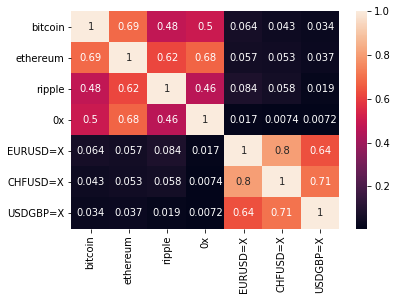

In [324]:
sns.heatmap(df_returns.corr(), xticklabels=df_returns.corr().columns, yticklabels=df_returns.corr().columns, annot=True)

#### Future Moments Estimation

In [325]:
w = input_dict["N. Periods Moments Estimation"][0]

In [326]:
def cov2corr(cov, return_std=False):
    cov = np.asanyarray(cov)
    std_ = np.sqrt(np.diag(cov))
    corr = cov / np.outer(std_, std_)
    if return_std:
        return corr, std_
    else:
        return corr

### EWMA

In [327]:
decay_factor = 0.95

df_ret = df_returns.ewm(alpha=decay_factor, min_periods = w).mean().dropna()

if method == "EWMA":
    #Future returns estimator

    df_cov_estimation = df_returns.ewm(alpha=decay_factor, min_periods = w).cov().dropna()
    df_std_estimation = df_returns.ewm(alpha=decay_factor, min_periods = w).std().dropna()
    df_corr_estimation = df_returns.ewm(alpha=decay_factor, min_periods = w).corr().dropna()

    df_ret.mean() * 360/lag_returns

### PCA

In [328]:
if method == "PCA":
    pca = sklearnPCA() # let's look at the first 3 components

    pc = pca.fit(df_returns.iloc[:w])

    pca_df = pd.DataFrame({"Component": list(range(1,len(assets_id) + 1)), "Variance Explained": pc.explained_variance_ratio_})

    fig = px.bar(pca_df, x='Component', y='Variance Explained',title='Principal Components Analysis')
    fig.show()
    pca = sklearnPCA(n_components=3) # let's look at the first 3 components


    idx = pd.MultiIndex.from_product([df_returns.index[w - 1:],
                                      assets_id],
                                     names=['Date', 'Assets'])
    df_cov_estimation = pd.DataFrame(0, idx, assets_id)
    df_corr_estimation = pd.DataFrame(0, idx, assets_id)
    df_std_estimation = pd.DataFrame(0, df_returns.index[w - 1:], assets_id)
    
    for i in range(0, len(df_returns) - (w - 1)):
        pc = pca.fit(df_returns.iloc[i:w+i])
        factor_ret = pc.transform(df_returns.iloc[i:w+i])
        cov_fac_ret = np.cov(factor_ret, rowvar=False)
        mu = pc.mean_
        factor_loadings =  pc.components_
        pred_fact_ret = factor_ret.dot(factor_loadings)
        for j in range(len(assets_id)):
            pred_fact_ret[j, :] += mu[j]
        unexplained_ret = df_returns.iloc[i:w+i] - pred_fact_ret
        unexplained_ret_cov = np.cov(unexplained_ret, rowvar=False)
        D = np.diag(unexplained_ret_cov)
        cov_estimated = factor_loadings.T.dot(cov_fac_ret.dot(factor_loadings)) + D
        df_cov_estimation.loc[df_returns.iloc[w+i-1].name] = cov_estimated
        corr_matrix, stds = cov2corr(cov_estimated, True)
        df_corr_estimation.loc[df_returns.iloc[w+i-1].name] = corr_matrix
        df_std_estimation.loc[df_returns.iloc[w+i-1].name] = stds
        

In [329]:
df_cov_estimation.head()

bitcoin  ethereum    ripple        0x  EURUSD=X  \
Date       Assets                                                       
2018-10-15 bitcoin   0.003039  0.003595  0.002272  0.002712  0.000026   
           ethereum  0.003189  0.004583  0.004135  0.005340  0.000029   
           ripple    0.002641  0.004910  0.010148  0.004615  0.000055   
           0x        0.003055  0.006089  0.004589  0.011922  0.000017   
           EURUSD=X  0.000396  0.000805  0.000056  0.000044  0.000016   

                     CHFUSD=X  USDGBP=X  
Date       Assets                        
2018-10-15 bitcoin   0.000026  0.000038  
           ethereum  0.000031  0.000034  
           ripple    0.000059  0.000034  
           0x        0.000023  0.000020  
           EURUSD=X  0.000020  0.000025

In [330]:
df_std_estimation.head()

,bitcoin,ethereum,ripple,0x,EURUSD=X,CHFUSD=X,USDGBP=X
2018-10-15,0.055124,0.067701,0.100737,0.109188,0.004052,0.004522,0.004964
2018-10-16,0.055214,0.067855,0.100936,0.109205,0.004070,0.004544,0.004981
2018-10-17,0.055202,0.067850,0.100955,0.109614,0.003981,0.004485,0.004941
2018-10-18,0.055104,0.067862,0.100950,0.109627,0.004005,0.004520,0.005014
2018-10-19,0.055123,0.067804,0.100889,0.109511,0.003992,0.004427,0.004974


# Alternative Portfolio Allocation


__Global Minimum Variance (GMV)__ 

This portfolio minimizes the portfolio volatility.

$$\underset{w'1_N = 1, w = [0, 1]}{\operatorname{argmin}} w'\Sigma w$$

__Maximum Diversification Ratio (MDR)__

Choueifaty and Coignard (2008) propose a measure of portfolio diversification taking in account volatility and correlation of the assets. The result is the so-called Diversification Ratio:

$$DI = \frac{\sum \sigma_i w_i}{ w'\Sigma w}$$

Where the numerator is the sum of the volatility of the single assets and the denominator is the volatility of the whole portfolio. In other words, this measure of diversification can be summarized as the distance between the individual volatility components and the volatility of the portfolio. The strategy maximizes this index as follows:

$$\underset{w'1_N = 1, w = [0, 1]}{\operatorname{argmax}} DI$$

__Equally Weighted (EW)__

This portfolio assign an equal weight to the all the constituents, so the weight for each single asset is:

$$\frac{1}{N}$$

where:
<br>
$N$ = number of the assets in the portfolio


## Economics of the Constraints

The applied constraints with the related economics are as follows:

- $w'1_N = 1$, sum of the weights is 1, so is not possible to have leverage. This is coherent with the assumption that the investor will not borrow money but use only his wealth
- $w = [0, 1]$, the lower bound of the weights is 0, assuming is not possible to short the underlying. In crypto currency would be currently possible short selling thanks to future market
- $\delta w$ (turnover) = turnover is capped at +/- 20% of single weight change

In [394]:
weights = np.array([1/len(assets_id ) for asset in assets_id])
wgt_only_eth = np.array([0 for asset in assets_id])
wgt_only_eth[assets_id.index("ethereum")] = 1
ew_weights =  weights
wgt_t0 = weights

In [395]:
def var_port(weights):
    return np.transpose(weights).dot(sigma.dot(weights))
def DEC(wrights):
    return np.transpose(weights).dot(rho.dot(weights)) - 1
def MDR(weights):
    VA = np.sqrt(np.transpose(stds)) * weights
    VP = np.sqrt(var_port(weights))
    return -sum(VA/VP)
def ERC(weights):
    rc = sigma.dot(weights)
    total_rc = 0
    for i, wi in enumerate(weights):
        for j, wj in enumerate(weights):
            total_rc = total_rc + (wi * rc[i] - wj * rc[j])**2
    return total_rc

def turnover(weights_t, weights_t1):
    return sum(abs(weights_t1 - weights_t))
def calc_draw_down(returns):
    DD = np.zeros(len(returns))
    for i in range(1, len(DD)):
        DD[i] = min(0,((1+ DD[i - 1]) * (1 + returns[i]) - 1))
    return DD
def calc_VaR(returns, percentile, time_horizon):
    return np.percentile(returns, percentile) * np.sqrt(time_horizon)
def calc_ES(returns, percentile, time_horizon):
    return np.average(np.array([ret for ret in returns if ret <= np.percentile(returns, percentile)])) * np.sqrt(time_horizon)

In [396]:
i = 0
contraints = []
constraints_assets = {}

for constrain in input_dict["Constraint Assets"]:
    if constrain == "Default Constraints":   
        def constraint_default(weights):
            return sum(abs(weights)) - 1
        contraints.append({'type': 'eq', 'fun': constraint_default})
        bounds = [(0, 1) for i in range(len(assets_id))]
    elif constrain == "Turnover":
        turnover_constraint = 0.2
    elif constrain == "Volatility":
        def constraint_vol(weights):
            return np.sqrt(var_port(weights)) - input_dict["Constraint Value"][i]
        contraints.append({'type': 'eq', 'fun': constraint_vol})
    else:
        try:
            constraints_assets[input_dict["Constraint Group"][i]].append((input_dict["Constraint Assets"][i],
                                                                     input_dict["Constraint Type"][i],
                                                                    input_dict["Constraint Value"][i]))
        except KeyError:
            constraints_assets[input_dict["Constraint Group"][i]] = [(input_dict["Constraint Assets"][i],
                                                                     input_dict["Constraint Type"][i],
                                                                    input_dict["Constraint Value"][i])]
    i = i + 1
    
i = 0

for key in constraints_assets:
    sum_assets = 0
    if len(constraints_assets[key]) == 1:
        if constraints_assets[key][0][1] == "Min":
           min_bound = constraints_assets[key][0][2]
        else:
            min_bound = 0
        if constraints_assets[key][0][1] == "Max":
            max_bound = constraints_assets[key][0][2]
        else:
            max_bound = 1
        bounds[assets_id.index(constraints_assets[key][0][0])] = (min_bound, max_bound)
    else:
        assets = [asset[0] for asset in constraints_assets[key]]
        idx_assets = [assets_id.index(asset) for asset in assets]
        def constraint_assets_weights(weights):
            return sum(abs(weights[idx_assets])) - constraints_assets[key][0][2] 
        contraints.append({'type': 'eq', 'fun': constraint_assets_weights})
    i = i + 1

                

def constraint2(weights):
    return sum(abs(weights[3:])) - 0.25


contraints = [{'type': 'eq', 'fun': constraint_default}, {'type': 'eq', 'fun': constraint_assets_weights}]
#contraints = [{"type": "eq", "fun": fun} for fun in constraints_list]
#bounds = [(0, 1), (0, 1), (0, 1), (0, 1), (0, 1) ,(0.25*0.5, 1)]


transaction_cost = 0.001


ONLY ETH
GMV
MDR
ERC
CAP_WGT
EW


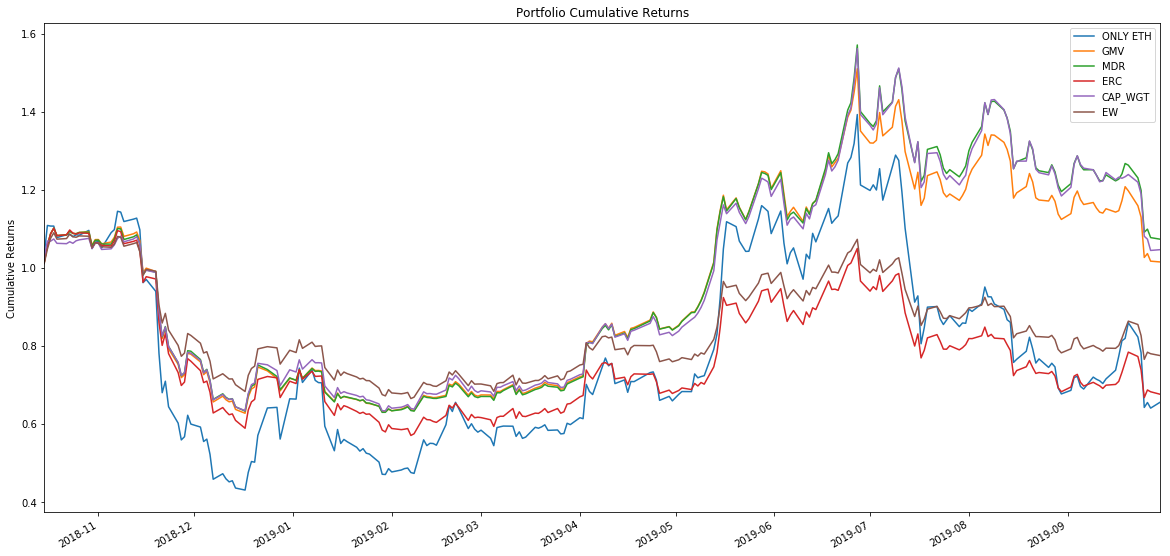

In [397]:


rebalancing_dates = pd.date_range(df_ret.index[0], df_ret.index[-1], freq=str(rebalancing_period) + 'D')
strategies = {"ONLY ETH": wgt_only_eth, "GMV" : var_port, "MDR": MDR,"ERC": ERC,"CAP_WGT": weights, "EW": weights}
columns_df_port_return = ["Return", "CumRet", "DrawDown", "Turnover", "PV"]
columns_df_port_return.extend(assets_id)
dict_df_port_returns = {}
df_ports_comparison = pd.DataFrame(columns=["Strategy", "Mean(Yearly)", "Std(Yearly)", "Min(Daily)", "Max(Daily)", 
                                            "Sharpe Ratio", "Sortino Ratio", "Maximum Drawdown"])




fig, ax = subplots(figsize=(20,10))

for strategy in strategies.keys():
    df_port_returns = pd.DataFrame(index=df_ret.index, columns=columns_df_port_return)
    wgt = wgt_t0
    print(strategy)
    for index in df_port_returns.index:
        if strategy == "ONLY ETH":
            df_port_returns.loc[index, assets_id] = wgt_only_eth.round(2)
            df_port_returns.loc[index, "Turnover"] = 0
            wgt = wgt_only_eth
        elif (strategy == "CAP_WGT") & (index in rebalancing_dates):
            wgt_t = wgt
            crypto_weights = np.array(df_market_cap.loc[index, crypto_id] / sum(df_market_cap.loc[index, crypto_id]) * 0.75)
            fiat_weights = np.array([0.0625, 0.0625, 0.125])
            df_port_returns.loc[index, crypto_id] = crypto_weights
            df_port_returns.loc[index, fiat_id] = fiat_weights
            df_port_returns.loc[index, "Turnover"] = turnover(wgt_t, wgt.round(2))
            wgt = np.concatenate((crypto_weights, fiat_weights), axis=0)
        elif strategy == "EW":
            df_port_returns.loc[index, assets_id] = ew_weights
            df_port_returns.loc[index, "Turnover"] = 0
            wgt = ew_weights
        elif index not in rebalancing_dates:
            df_port_returns.loc[index, assets_id] = wgt.round(2)
            df_port_returns.loc[index, "Turnover"] = 0
        else:
            wgt_t = wgt
            stds = df_std_estimation.loc[index].values
            rho = df_corr_estimation.loc[index].values
            sigma = df_cov_estimation.loc[index].values
            if turnover_constraint > 0:
                bounds = [(max(0, (w * (1 - turnover_constraint))),w* ( 1 + turnover_constraint)) for w in wgt_t]
            opt_fun = minimize(strategies[strategy], weights, method='SLSQP', bounds=bounds, constraints=contraints)
            wgt = opt_fun.x 
            df_port_returns.loc[index, assets_id] = wgt.round(2)
            df_port_returns.loc[index, "Turnover"] = turnover(wgt_t, wgt.round(2))
        df_port_returns.loc[index, "Return_Adjusted_TransCost"] = sum(wgt * df_returns.loc[index].values.round(4) - df_port_returns.loc[index, "Turnover"] * transaction_cost) 
        df_port_returns.loc[index, "Return"] = round(sum(wgt * df_returns.loc[index].values), 4)
        df_port_returns.loc[index, "PV"] = round(sum(wgt * df_prices.loc[index].values), 4)
    df_port_returns["CumRet"] = np.cumprod(1 + df_port_returns["Return"].values)
    df_port_returns["CumRet"].plot(ax=ax)
    df_port_returns["DrawDown"] = calc_draw_down(df_port_returns["Return"].values)
    dict_df_port_returns[strategy] = df_port_returns
    df_ports_comparison = df_ports_comparison.append({"Strategy": strategy,
                                                     "Mean(Yearly)": df_port_returns["Return"].mean() * 360/lag_returns,
                                                     "Std(Yearly)": df_port_returns["Return"].std() * np.sqrt(252/lag_returns),
                                                     "CumRet": df_port_returns.CumRet.iloc[-1],
                                                      "Min(Daily)": df_port_returns["Return"].min(),
                                                     "Max(Daily)": df_port_returns["Return"].max(), 
                                                     "Sortino Ratio": df_port_returns["Return"].mean() / df_port_returns["Return"][(df_port_returns["Return"] < 0)].std(),
                                                     "Maximum Drawdown": df_port_returns["DrawDown"].min()},
                                                     ignore_index=True)
ax.set_title("Portfolio Cumulative Returns")
ax.set_ylabel("Cumulative Returns")
ax.legend(strategies)
df_ports_comparison["Sharpe Ratio"] = df_ports_comparison["Mean(Yearly)"] / df_ports_comparison["Std(Yearly)"]


# Performance Evaluation

__Cumulative Returns__

A way to measure performance of a portfolio is to break down the cumulated return across the time interval considered.
Cumulated return are compounded by a cumulative product of the return for every weighting scheme with initial value of 1, since it’s suppose that the investment is 100% of investor’s wealth (as a matter of fact, all the assets weights are normalized to 1).

The cumulative returns are calculated as follows:

$${\prod_{t=1}^{T} (1 + r_t)}$$

where:
<br>
$r_t$ = portfolio return at time T


__Sharpe Ratio__

The Sharpe Ratio is the risk-adjusted return, calculated as the ratio between return and volatility of the portfolio.

$$ SR = \frac{r_p}{\sigma}$$

where:
<br>
$r_p$ = portfolio return
<br>
$sigma$ = portfolio standard deviation

__Sortino Ratio__

The Sortino Ratio is a modification of Sharpe Ratio, calculated as the ratio between excess return and downside risk. Downside risk is the volatility of negative asset return.

$$ SR = \frac{r_p}{\sigma_d}$$

where:
<br>
$r_p$ = portfolio return
<br>
$sigma$ = portfolio standard deviation of the negative returns

__Drawdown__

The drawdown sequence is calculated at each time t as follows:

$$D_t = min(0, (1+ D_{t-1} * (1 + R_t) - 1)$$

where:
<br>

$D_{t - 1}$ = drawdown at time t - 1
<br>
$R_t$ = portfolio return at time t

the Drawdown sequence is graphically analysed to identify the largest losses, and the time to recover from losses (a better
strategy has smaller losses and a quick recovery from the minimums). The Maximum Drawdown is the lowest value of the Drawdown sequence.

__VaR__

The VaR formula with parametric approach is the following:

$$ VaR(\alpha, T, \sigma) = \sigma * \sqrt{T} * \alpha$$

where:
<br>

$\sigma$ = standard deviation of the portfolio
<br>
$T$ = time horizon
<br>
$\alpha$ = inverse of standard normal distribution at pre-defined confidence interval
<br>
<br>
VaR($\alpha$) is the maximum loss a portfolio can experience over a time horizon $T$ with probability $1 - \alpha$.

We use the historical approach, taking a moving windows of 252 days, we choose the left-tail $\alpha$ as VaR.


__Expected Shortfall__

The Expected Shortfall is a variation of VaR calculating the average of the losses equal or greater of the VaR. This risk measure captures the most extreme tail risk.

In [398]:
df_ports_comparison = df_ports_comparison.round(2)
df_ports_comparison["Mean(Yearly)"] = df_ports_comparison["Mean(Yearly)"].mul(100).map('{:.2f}%'.format)
df_ports_comparison["Std(Yearly)"] = df_ports_comparison["Std(Yearly)"].mul(100).map('{:.2f}%'.format)
df_ports_comparison["CumRet"] = df_ports_comparison["CumRet"].mul(100).map('{:.2f}%'.format)
df_ports_comparison["Min(Daily)"] = df_ports_comparison["Min(Daily)"].mul(100).map('{:.2f}%'.format)
df_ports_comparison["Max(Daily)"] = df_ports_comparison["Max(Daily)"].mul(100).map('{:.2f}%'.format)
df_ports_comparison["Maximum Drawdown"] = df_ports_comparison["Maximum Drawdown"].mul(100).map('{:.2f}%'.format)
df_ports_comparison

,Strategy,Mean(Yearly),Std(Yearly),Min(Daily),Max(Daily),Sharpe Ratio,Sortino Ratio,Maximum Drawdown,CumRet
0,ONLY ETH,-7.00%,87.00%,-18.00%,18.00%,-0.08,-0.01,-62.00%,66.00%
1,GMV,20.00%,50.00%,-11.00%,11.00%,0.40,0.02,-43.00%,102.00%
2,MDR,29.00%,50.00%,-11.00%,11.00%,0.57,0.03,-43.00%,107.00%
3,ERC,-38.00%,53.00%,-12.00%,10.00%,-0.71,-0.04,-48.00%,68.00%
4,CAP_WGT,26.00%,51.00%,-11.00%,11.00%,0.50,0.03,-41.00%,105.00%
5,EW,-26.00%,41.00%,-9.00%,7.00%,-0.63,-0.04,-39.00%,78.00%


# Winner Portfolios

According to Sharpe Ratio, the best performing portfolios are:
 - MDR
 - GMV
 - DEC
 - ONLY ETH
 
__However, MDR, GMV and DEC portfolios outperform the ONLY ETH strategy both in terms of rewards (higher yearly mean return, higher cumulative returns, higher sharpe ratio) and in terms of risk (lower std deviation, lower VaR, lower ES).__ 

In [399]:
def plot_portfolio_weights(df_port, strategy):
    data = []
    for asset in assets_id:
        data.append(go.Bar(x=df_port.index, y=df_port[asset], name=asset))   

    layout = go.Layout(barmode='stack',  title='Portoglio Weights for strategy ' + strategy)
    fig = go.Figure(data=data, layout=layout)
    
    fig.show()
    
    
def plot_portfolio_weights_2(df_port):
    ticks = df_port.index[::200]
    ax = df_port.plot(kind="bar", stacked=True, figsize=(15,10), width=1.0)
    ax.set_xticklabels(ticks, rotation=45)
    ax

In [400]:
plot_portfolio_weights(dict_df_port_returns["CAP_WGT"], "CAP_WGT")

In [401]:
plot_portfolio_weights(dict_df_port_returns["MDR"], "MDR")

In [402]:
plot_portfolio_weights(dict_df_port_returns["GMV"], "GMV")

In [403]:
plot_portfolio_weights(dict_df_port_returns["ERC"], "ERC")

Text(0.5, 1.0, 'DrawDown Sequence')

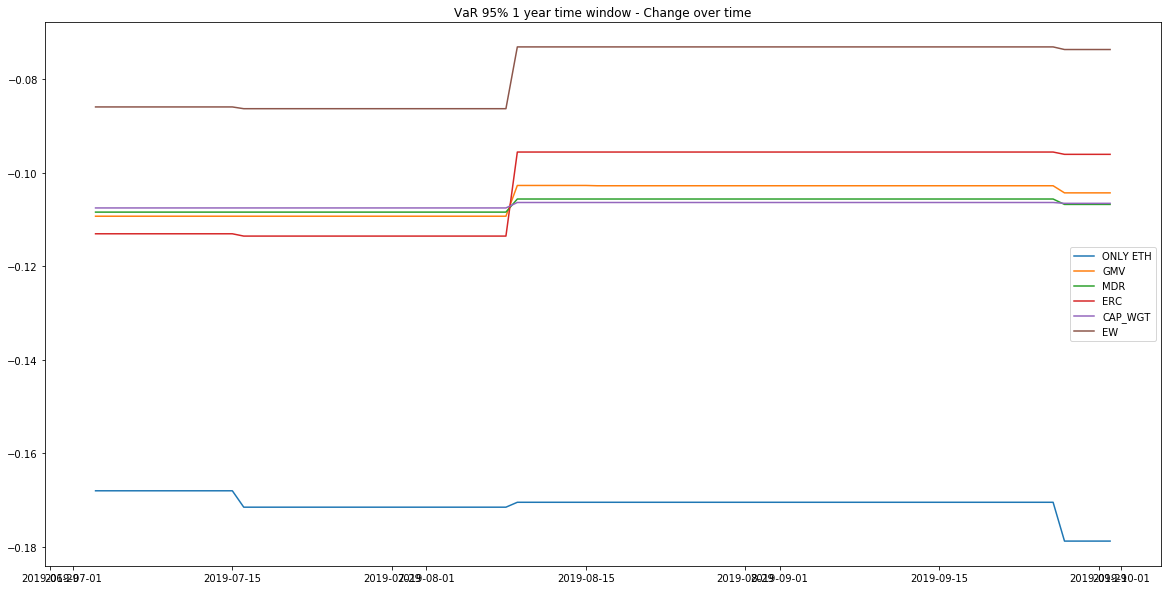

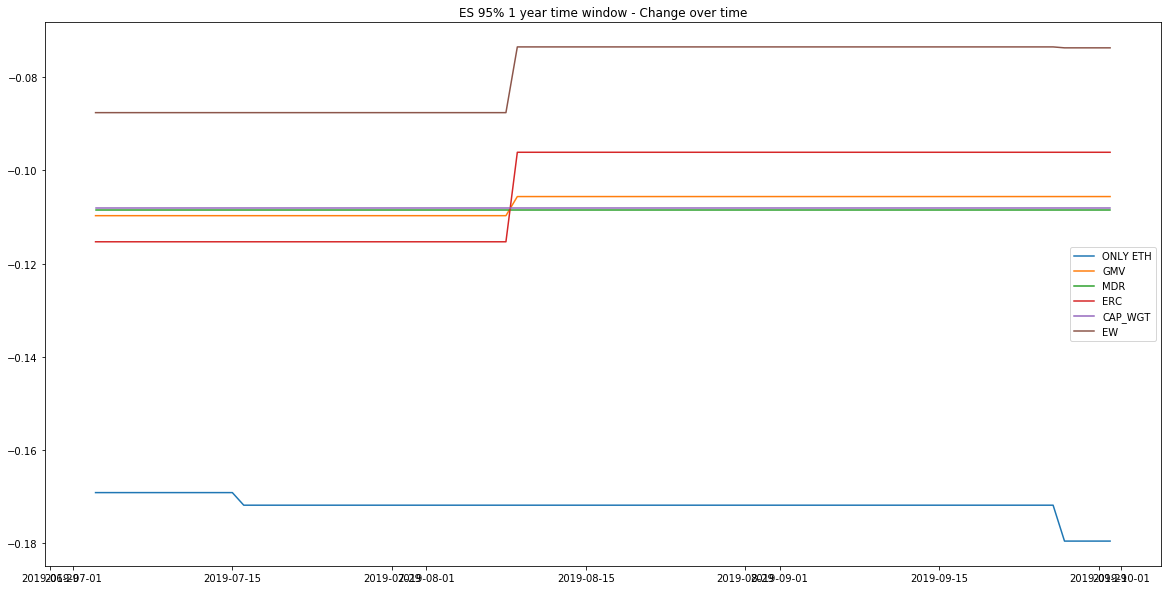

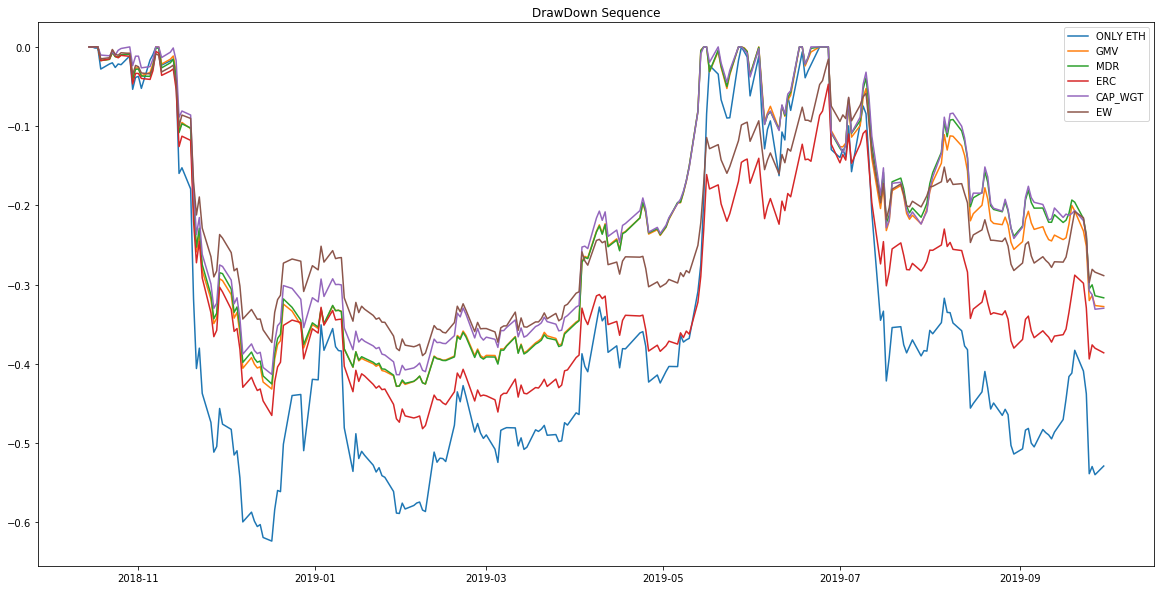

In [409]:
time_window = 180
confidence_interval = 0.05
time_horizon = 1

fig, plt_var = subplots(figsize=(20,10))
fig2, plt_es = subplots(figsize=(20,10))
fig3, plt_drawdown = subplots(figsize=(20,10))

for strategy in dict_df_port_returns.keys():
    dates_var_es = dict_df_port_returns[strategy].iloc[time_window:].loc[:, "Return"].index
    dates_drawdown = dict_df_port_returns[strategy].index
    var = np.zeros(len(dict_df_port_returns[strategy]) - time_window)
    es = np.zeros(len(dict_df_port_returns[strategy]) - time_window) 
    for i in range(len(dict_df_port_returns[strategy]) - time_window):
        var[i] = calc_VaR(dict_df_port_returns[strategy].iloc[i:time_window + i].loc[:, "Return"].values, confidence_interval, time_horizon)
        es[i] =  calc_ES(dict_df_port_returns[strategy].iloc[i:time_window + i].loc[:, "Return"].values, confidence_interval, time_horizon)
    plt_var.plot(dates_var_es, var)
    plt_es.plot(dates_var_es, es)
    plt_drawdown.plot(dates_drawdown, dict_df_port_returns[strategy].loc[:, "DrawDown"].values)

plt_var.legend(strategies)
plt_var.set_title("VaR 95% 1 year time window - Change over time")
plt_es.legend(strategies)
plt_es.set_title("ES 95% 1 year time window - Change over time")
plt_drawdown.legend(strategies)
plt_drawdown.set_title("DrawDown Sequence")

In [404]:
wks_name = 'Performance Evaluation'
d2g.upload(df_ports_comparison, spreadsheet_key, wks_name, credentials=creds, row_names=True)

<Worksheet 'Performance Evaluation' id:877164004>

In [405]:
for strategy in dict_df_port_returns:
    wks_name = strategy
    d2g.upload(dict_df_port_returns[strategy], spreadsheet_key, wks_name, credentials=creds, row_names=True)